Пока заглушка, делаю..

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [1]:
import os
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ks_2samp

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 40)

Data Set Information:

The skin dataset is collected by randomly sampling B,G,R values from face images of various age groups (young, middle, and old), race groups (white, black, and asian), and genders obtained from FERET database and PAL database. Total learning sample size is 245057; out of which 50859 is the skin samples and 194198 is non-skin samples. Color FERET Image Database: , PAL Face Database from Productive Aging Laboratory, The University of Texas at Dallas: .


Attribute Information:

This dataset is of the dimension 245057 * 4 where first three columns are B,G,R (x1,x2, and x3 features) values and fourth column is of the class labels (decision variable y). 

In [3]:
data = pd.read_csv("Skin_NonSkin.txt", sep='\t', header=None)
data.drop_duplicates(inplace=True)
data.rename( columns={0:'b',1:'g',2:'r',3:'target'}, inplace=True)
data['target'] = data['target'].apply(lambda x: 0 if x == 2 else 1)
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data

(51444, 4)


,b,g,r,target
0,245,195,189,0
1,126,93,14,0
2,114,141,168,1
3,92,148,225,1
4,102,91,101,0
...,...,...,...,...
51439,125,128,82,0
51440,80,180,238,0
51441,138,138,192,1
51442,51,119,186,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51444 entries, 0 to 51443
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   b       51444 non-null  int64
 1   g       51444 non-null  int64
 2   r       51444 non-null  int64
 3   target  51444 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


In [5]:
data.describe()

,b,g,r,target
count,51444.000000,51444.000000,51444.000000,51444.000000
mean,109.041871,121.731942,137.409066,0.284853
std,62.269318,58.440226,76.947186,0.451349
min,0.000000,0.000000,0.000000,0.000000
25%,57.000000,79.000000,71.000000,0.000000
50%,107.000000,126.000000,141.000000,0.000000
75%,154.000000,167.000000,210.000000,1.000000
max,255.000000,255.000000,255.000000,1.000000


In [6]:
target = data['target']
data = data.drop('target', axis=1)

In [44]:
num_col = ['b', 'g', 'r']

In [45]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=68
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=68
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 41155 rows, 3 cols
x_valid.shape = 10289 rows, 3 cols


In [9]:
print("y_train.shape = {} rows".format(*y_train.shape))
print("y_valid.shape = {} rows".format(*y_valid.shape))

y_train.shape = 41155 rows
y_valid.shape = 10289 rows


In [10]:
def plot_stat_distribution(train: pd.Series, test: pd.Series):
    """
    Визуализация признака для обучающих и тестовых данных;

    Parameters
    ----------
    train: pandas.core.frame.Series
        Значение признака на обучении.

    test: pandas.core.frame.Series
        Значение признака на тесте.

    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    train.plot(ax=axes[0], color="#33137d")
    test.plot(ax=axes[1], color="#007539")
    plt.suptitle(f"Feature name - {train.name}")
    axes[0].set_title("Train Distribution")
    axes[1].set_title("Test Distribution")

    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    plt.axhline(0, color="red", linestyle="--", alpha=0.5)
    (train - test).plot(color="#33137d")
    plt.legend()

def plot_row_distribution(func: callable, train: pd.Series, test: pd.Series, axis: int = 1):
    """
    Визуализация распределения статистики по строке обучающих
    и тестовых данных.

    Parameters
    ----------
    func: callable
        Функция для вычисления статистики.

    train: pandas.core.frame.Series
        Значение признака на обучении.

    test: pandas.core.frame.Series
        Значение признака на тесте.

    axis: int, optional, default = 1
        Направление оси вдоль которой выполнять агрегацию данных.
        Значения могут быть: {0 or 'index', 1 or 'columns'}
        Опциональный параметр, по умолчанию, равен 1.

    """
    plt.figure(figsize=(15, 5))
#     test = test.drop("ID_code", axis=1).copy()
#     train = train.drop(["ID_code", "target"], axis=1).copy()
    test_stats = test.apply(func, axis=axis)
    train_stats = train.apply(func, axis=axis)

    plt.title("Distribution of mean values per row in the train and test set")
    sns.distplot(test_stats, color="#33137d", kde=True, bins=120, label='train')
    sns.distplot(train_stats, color="#007539", kde=True, bins=120, label='test')
    plt.xlabel(f"feature-{func}", size=13)
    plt.legend()
    plt.show()

In [11]:
train_stats = x_train.describe()
test_stats = x_valid.describe()

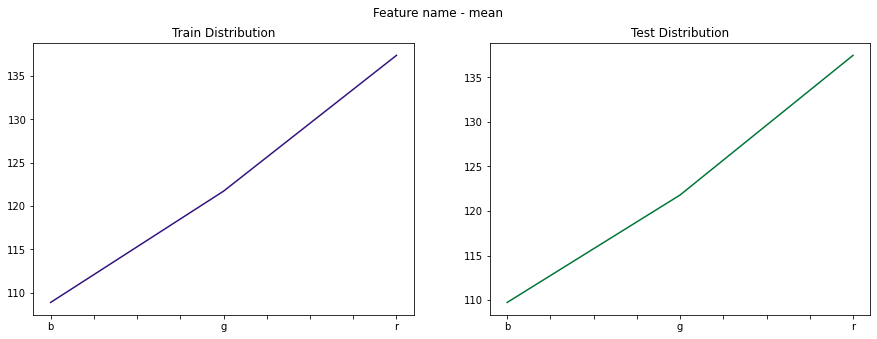

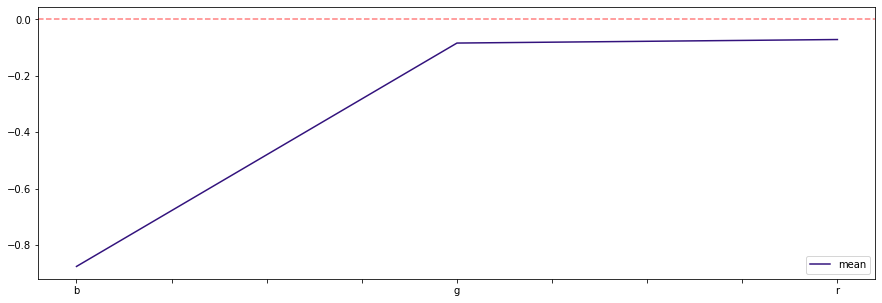

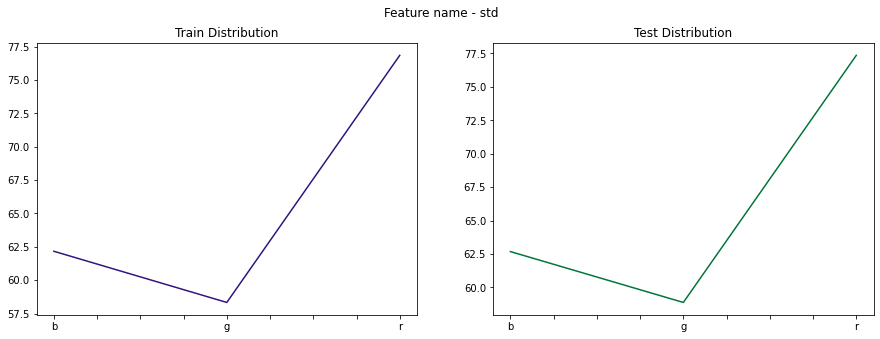

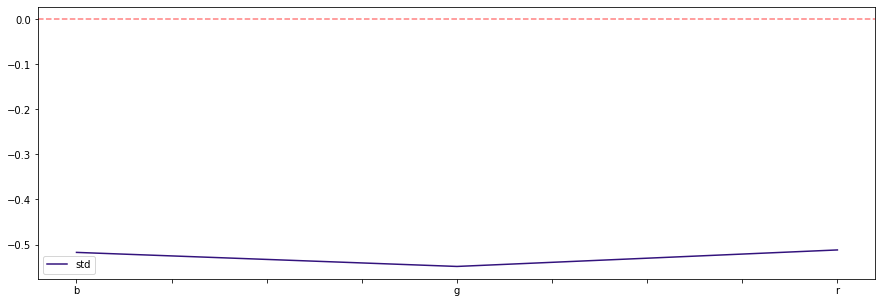

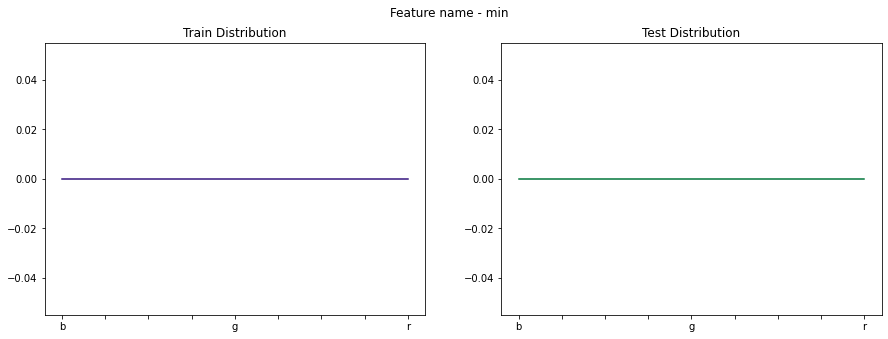

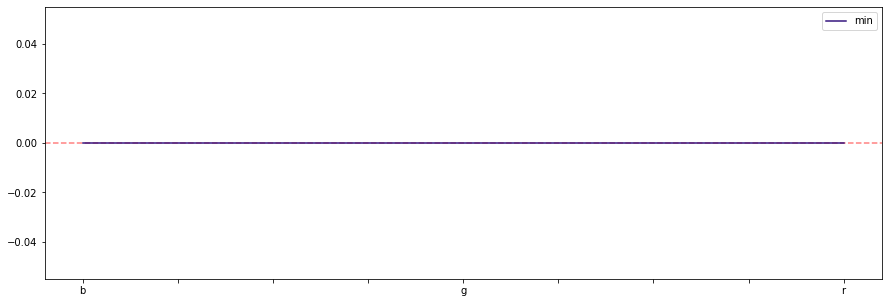

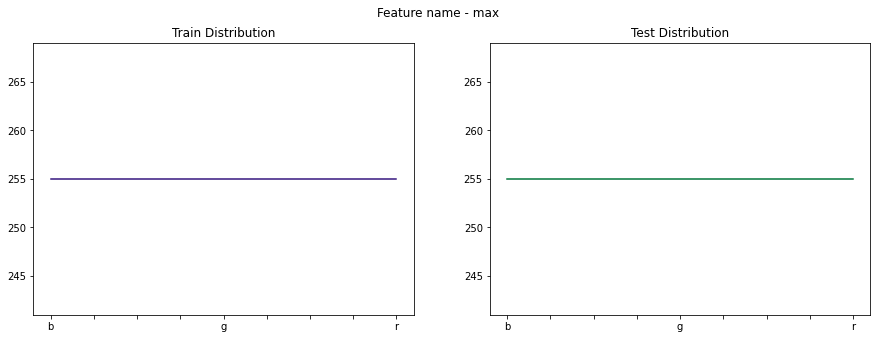

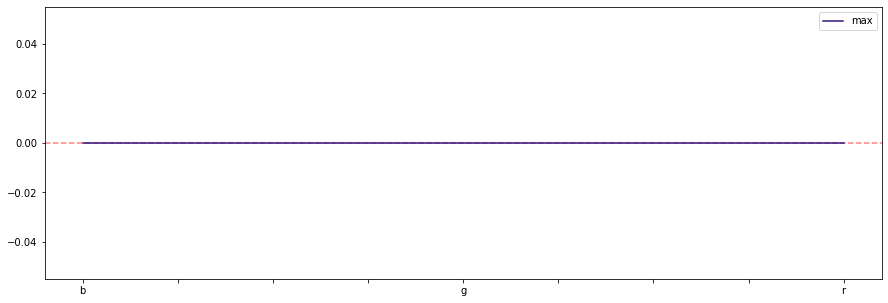

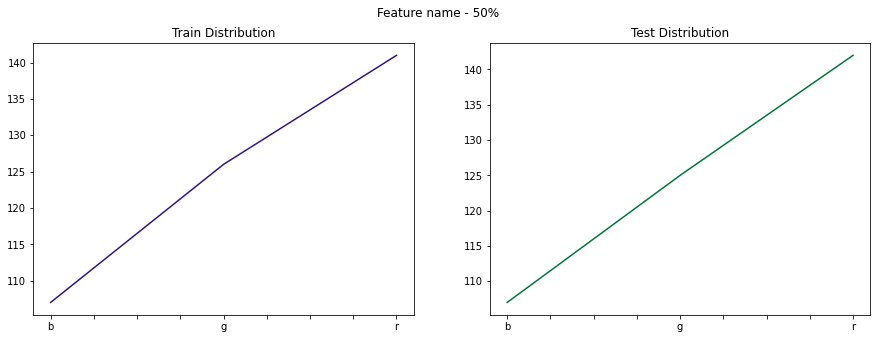

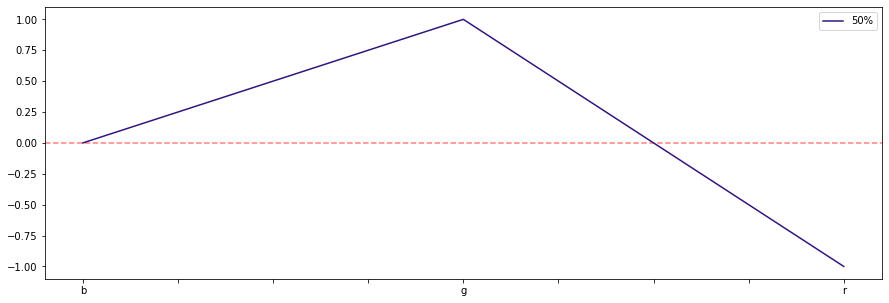

In [12]:
for feature in ["mean", "std", "min", "max", "50%"]:
    plot_stat_distribution(train_stats.loc[feature], test_stats.loc[feature])

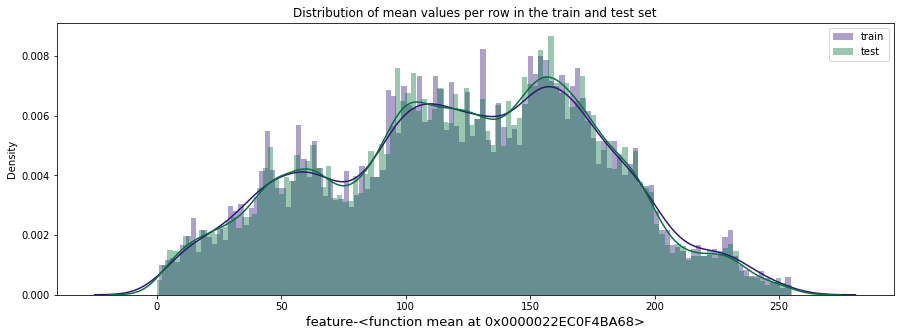

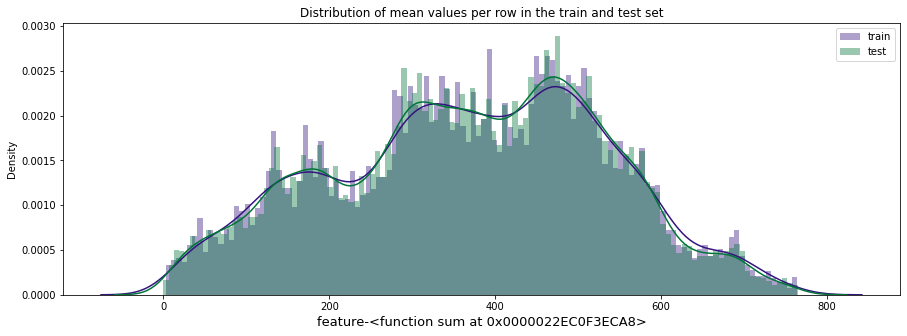

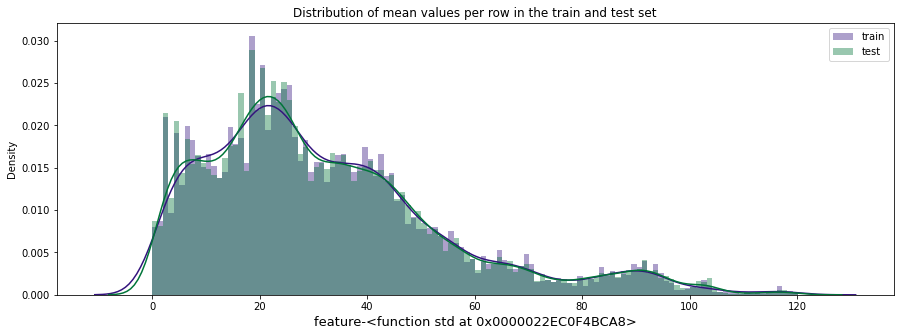

In [13]:
for func in [np.mean, np.sum, np.std]:
    plot_row_distribution(func, x_train, x_valid)

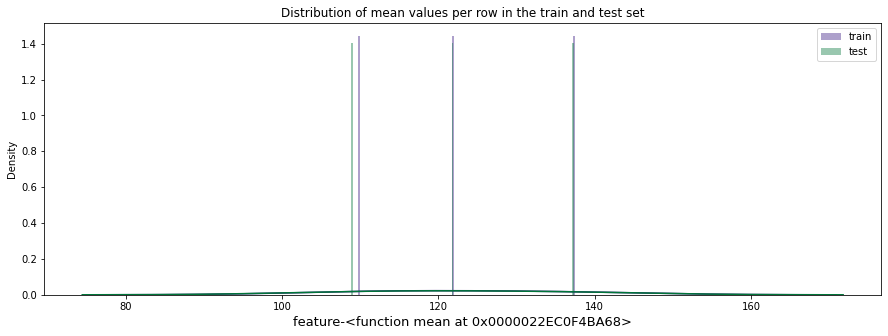

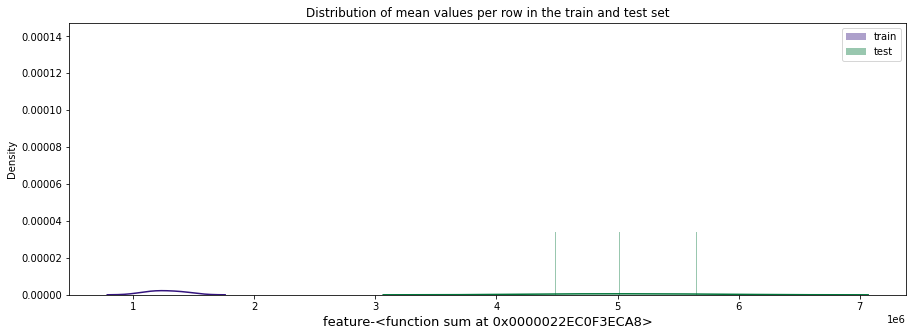

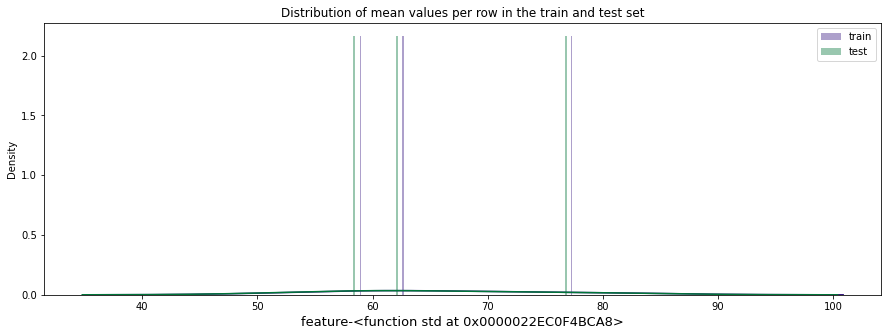

In [14]:
for func in [np.mean, np.sum, np.std]:
    plot_row_distribution(func, x_train, x_valid, axis=0)

На основе этой визуализации можно сделать несколько выводоы:

* стандартное отклонение достаточно большое (по сравнению со средним значение); отклонение велико как для обучающих данных, так и для тестовых данных.

* распределения всех статистик на обучающих и на тестовых данных отличаются для статистики `mean` и `std`.

* Есть отличия по статистикам по объектам.

* Выбросов, похоже, нет

## 2. Анализ целевой переменной

Mean-target: 0.2845


Text(0, 0.5, 'Index')

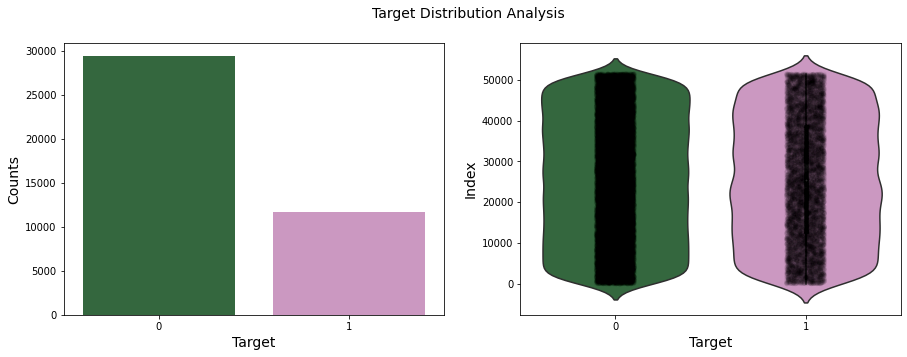

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Target Distribution Analysis", size=14)
print(f"Mean-target: {round(y_train.mean(), 4)}")

sns.countplot(y_train, ax=axes[0], palette="cubehelix")
sns.violinplot(y_train, y_train.index, ax=axes[1], palette="cubehelix")
sns.stripplot(y_train, y_train.index, jitter=True, ax=axes[1], color="black", alpha=0.05)

axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Counts", fontsize=14)
axes[1].set_xlabel("Target", fontsize=14)
axes[1].set_ylabel("Index", fontsize=14)

Сделаем первые выводы о целевой переменной:

* мы будем решать задачи бинарной классификации с дисбалансом целевой переменной. Количество точек, определенных как skin, намного меньше, чем точек, определенных иначе. При этом, дисбаланс не является критическим, а является вполне рабочей ситуацией. Какие-то манипуляции с данными для выравнивания баланса классов, в качестве приоритетных гипотез, рассматриваться не будут.

## 3. Анализ распределения признаков

In [16]:
features = ['b', 'g', 'r']

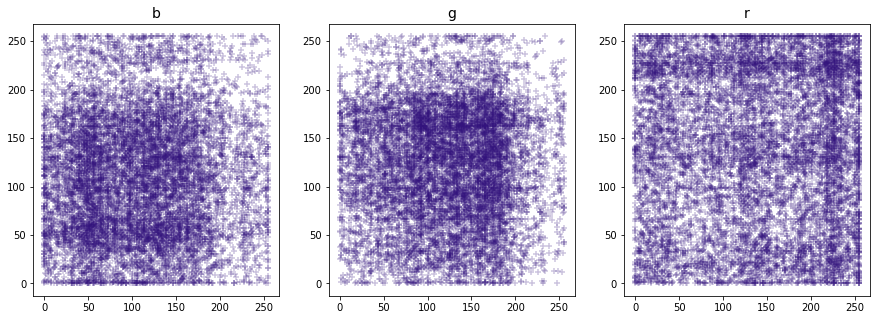

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for num, feature in enumerate(features, start=1):
    plt.subplot(1, 3, num)
    plt.title(f"{feature}", size=14)
    plt.scatter(
        x_train[feature].sample(10289),
        x_valid[feature], #.sample(5000),
        color="#33137d",
        alpha=0.25,
        marker="+")

Построим распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки

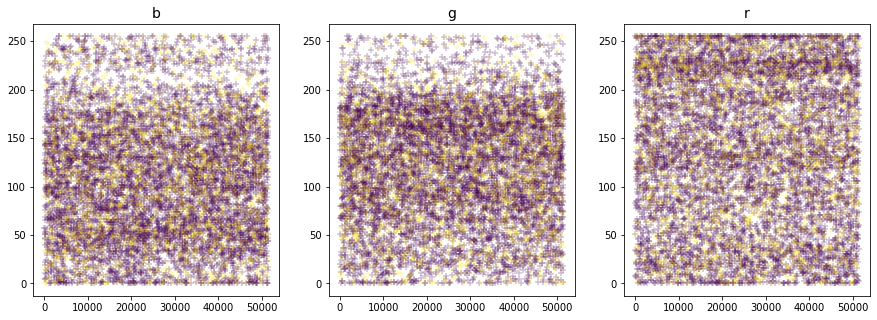

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for num, feature in enumerate(features, start=1):
    plt.subplot(1, 3, num)
    plt.title(f"{feature}", size=14)
    plt.scatter(
        x_train[feature].sample(10000).index,
        x_train[feature].sample(10000),
        c=y_train.sample(10000),
        cmap="viridis",
        alpha=0.25,
        marker="+")

In [19]:
def plot_features_distribution(train: pd.DataFrame, test: pd.DataFrame, features: List[str]):
    """
    Построение графика распределения признака на обучающем и тестовом наборе данных.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Обучающая выборка.

    test: pandas.core.frame.DataFrame
        Тестовая выборка.

    features: List[str]
        Список с названеим признаков.

    """
    n_rows, n_cols = 1, 3
#     if len(features) % 5:
#         n_rows += 1

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for num, feature in enumerate(features, start=1):
        plt.subplot(n_rows, n_cols, num)
        statistic, pvalue = ks_2samp(train[feature].sample(5000), test[feature].sample(5000))
        plt.title(f"{feature}, p-value = {round(pvalue, 4)}", size=14)
        sns.distplot(train[feature], hist=False, color="#33137d")
        sns.distplot(test[feature], color="#007539", hist=False)

def plot_features_target_distribution(train: pd.DataFrame, target: pd.Series, features: List[str]):
    """
    Построение графика распределения признака для
    разных значений целевой переменной.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Обучающая выборка.

    target: pandas.core.frame.Series
        Вектор целевой переменной.

    features: List[str]
        Список с названеим признаков.

    """
    n_rows, n_cols = 1,3
#     if len(features) % 5:
#         n_rows += 1

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for num, feature in enumerate(features, start=1):
        plt.subplot(n_rows, n_cols, num)
        positive_mask, negative_mask = target == 1, target == 0
        statistic, pvalue = ks_2samp(
            train.loc[positive_mask, feature].sample(5000),
            train.loc[negative_mask, feature].sample(5000)
        )
        plt.title(f"{feature}, p-value = {round(pvalue, 4)}", size=14)
        sns.distplot(train.loc[positive_mask, feature], hist=False, color="#33137d")
        sns.distplot(train.loc[negative_mask, feature], color="#007539", hist=False)

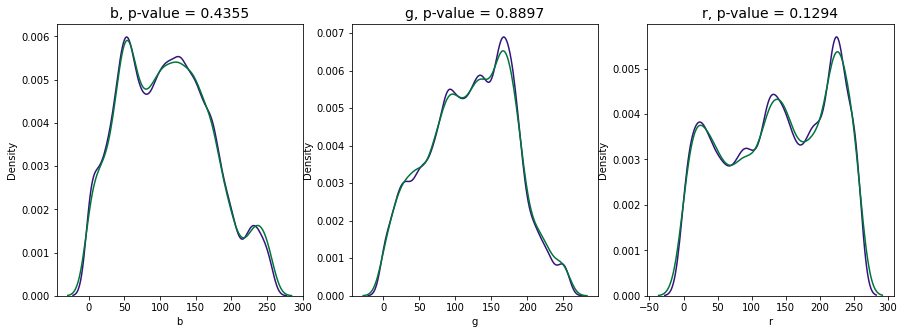

In [20]:
plot_features_distribution(x_train, x_valid, features=features)

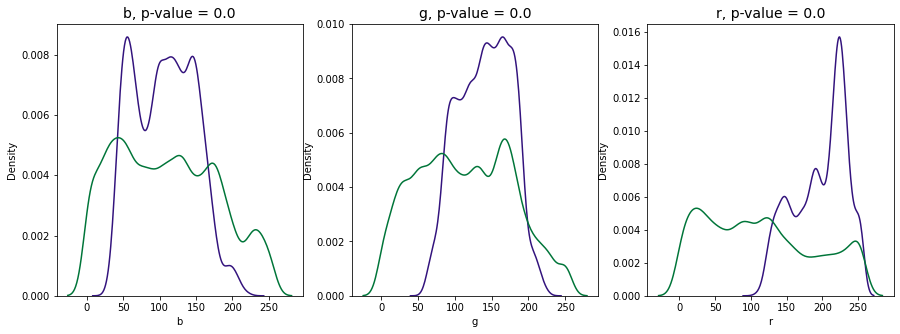

In [21]:
plot_features_target_distribution(x_train, y_train, features=features)

Сделаем некоторые выводы о распределении признаков:

* распределение значений признаков по индексам неоднородное, распределение объектов целевого класса по признакам тоже неоднородное, особенно отличается для 'b' и 'g', для 'r' особых отличий нет;

* распределение значений признаков на обучающей выборки и на тестовой выборке очень близко, что позволяет надеятся на стабильные результаты на валидации;

* в разрезе целевой переменной, выделяется очень большая разница в распределениях. Эти знания полезны для дальнейшего Feature Selection.

## 5. Связь между признаками

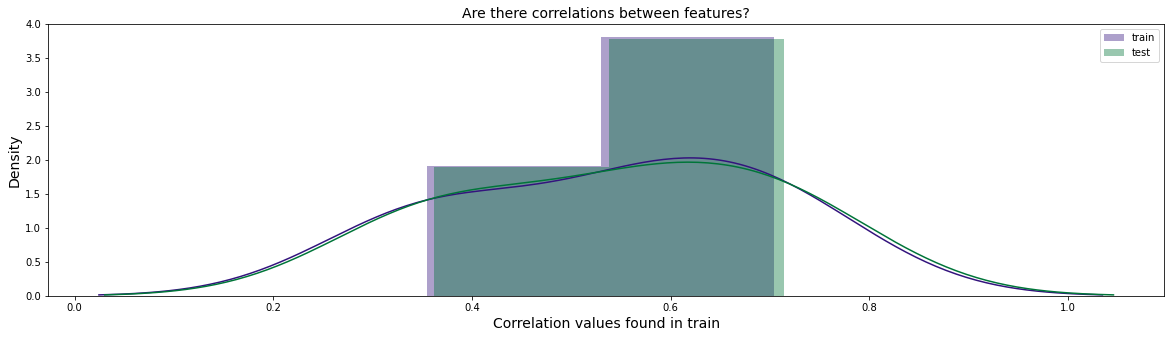

In [22]:
train_correlations = x_train.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = x_valid.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="#33137d", label="train")
sns.distplot(test_correlations, color="#007539", label="test")
plt.title("Are there correlations between features?", size=14)
plt.xlabel("Correlation values found in train", size=14)
plt.ylabel("Density", size=14)
plt.legend()

Корреляция довольно велика. Такая картина актуальна как для обучающей выборки, так и для тестовой выборки. 

Посмотрим на распределение признаков более детально. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


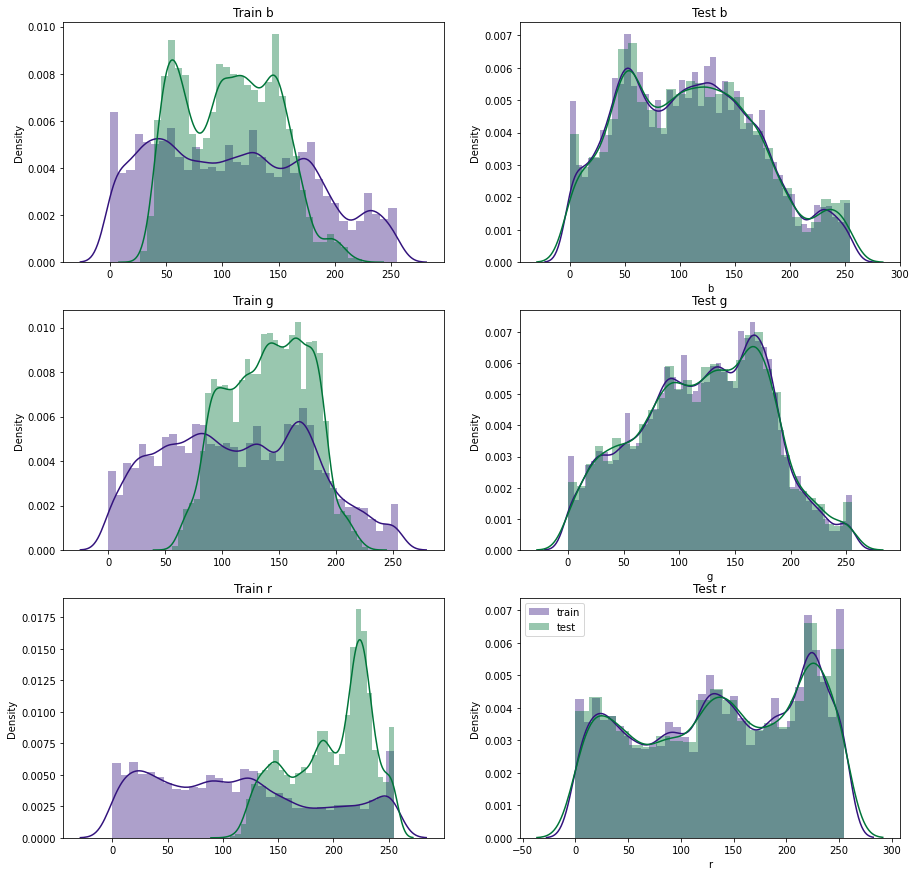

In [23]:
ntop = 3
fig, axes = plt.subplots(ntop, 2, figsize=(15, 5*ntop))

for n in range(ntop):
    sns.distplot(
        x_train.loc[y_train==0, features[n]],
        ax=axes[n, 0],
        color="#33137d",
        label="target=0",
        norm_hist=True,
    )
    sns.distplot(
        x_train.loc[y_train==1, features[n]],
        ax=axes[n, 0],
        color="#007539",
        label="target=1",
        norm_hist=True
    )
    sns.distplot(
        x_train.loc[:, features[n]],
        ax=axes[n, 1],
        color="#33137d", 
        norm_hist=True,
        label="train"
    )
    sns.distplot(
        x_valid.loc[:, features[n]],
        ax=axes[n, 1],
        color="#007539",
        norm_hist=True,
        label="test"
    )

    axes[n, 0].set_title("Train {}".format(features[n]))
    axes[n, 1].set_title("Test {}".format(features[n]))
    axes[n, 0].set_xlabel("")
    plt.legend(loc="best")

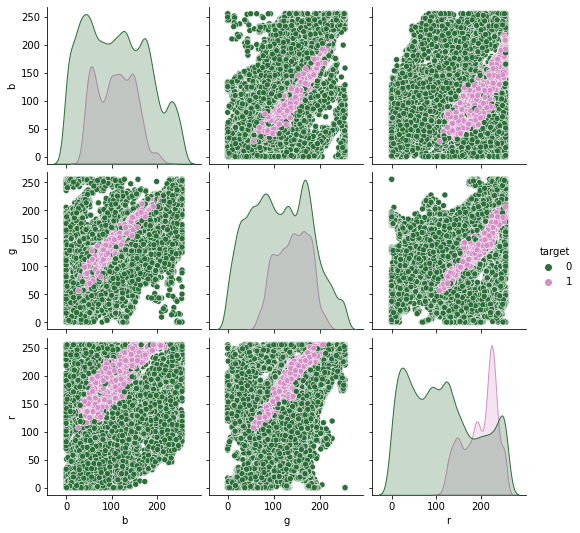

In [24]:
sns.pairplot(x_train.join(y_train), hue="target", palette="cubehelix")

__Вывод:__

* Целевая переменная хорошо выделяется на парных графиках

#### Анализ распределения признаков на обучении и на тесте

In [25]:
x_adv = pd.concat([
    x_train, x_valid
])
x_adv = x_adv.reset_index(drop=True)
# x_adv = x_adv.drop("ID_code", axis=1)

In [26]:
y_adv = np.hstack((
    np.zeros(x_train.shape[0]),
    np.ones(x_valid.shape[0])
))

In [27]:
cv = cross_val_score(
    estimator=xgb.XGBClassifier(n_estimators=25),
    X=x_adv, y=y_adv, cv=5, scoring="roc_auc"
)

[17:50:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [28]:
print(f"CV-mean: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-mean: 0.4934 +/- 0.004


Вывод: Adversarial validation показывает, что датасет разделен на тренировочную и тестовую часть корректно, с одинаковым распределением признаков

Сделаем Feature Engineerig

In [46]:
for col in num_col:
    x_train[col + '2'] = x_train[col].apply(lambda x: x**2)
    x_valid[col + '2'] = x_valid[col].apply(lambda x: x**2)
    x_train[col + '3'] = x_train[col].apply(lambda x: x**3)
    x_valid[col + '3'] = x_valid[col].apply(lambda x: x**3)
    x_train[col + '_log'] = np.log(x_train[col] + 0.00001)
    x_valid[col + '_log'] = np.log(x_valid[col] + 0.00001)    

In [47]:
x_train.shape, x_valid.shape

((41155, 12), (10289, 12))

In [48]:
x_train.head(3)

,b,g,r,b2,b3,b_log,g2,g3,g_log,r2,r3,r_log
37251,166,179,235,27556,4574296,5.111988,32041,5735339,5.187386,55225,12977875,5.459586
28505,33,10,142,1089,35937,3.496508,100,1000,2.302586,20164,2863288,4.955827
22298,110,110,74,12100,1331000,4.700480,12100,1331000,4.700480,5476,405224,4.304065


In [49]:
x_valid.head(3)

,b,g,r,b2,b3,b_log,g2,g3,g_log,r2,r3,r_log
20430,146,149,134,21316,3112136,4.983607,22201,3307949,5.003946,17956,2406104,4.897840
26752,94,57,43,8836,830584,4.543295,3249,185193,4.043051,1849,79507,3.761200
19623,13,17,11,169,2197,2.564950,289,4913,2.833214,121,1331,2.397896


In [50]:
num_col = x_train.columns.to_list()
num_col

['b', 'g', 'r', 'b2', 'b3', 'b_log', 'g2', 'g3', 'g_log', 'r2', 'r3', 'r_log']

Обучим модель

In [51]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [52]:
dtrain = xgb.DMatrix(
    data=x_train[num_col], label=y_train
)

dvalid = xgb.DMatrix(
    data=x_valid[num_col], label=y_valid
)


In [53]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
#     early_stopping_rounds=50,
#     evals=[(dtrain, "train"), (dvalid, "valid")],
#     verbose_eval=50,
    maximize=True,
)

[17:57:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [54]:
y_probas = model.predict(dvalid).tolist()

In [55]:
y_true = y_valid.to_list()

In [56]:
fpr, tpr, _ = roc_curve(y_true, y_probas)

In [57]:
roc_auc_score(y_true, y_probas)

0.9965897571551189

SHAP: построим важности признаков для:

    всего тестового набора данных (summary_plot - дадим интерпретацию)
    для топ 10%

для отдельных наблюдений выведем force_plot и проинтерпретируем результат

In [58]:
import shap

# load JS visualization code to notebook
shap.initjs()

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import itertools


In [59]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_valid.iloc[0,:])

Для значения выше признаки r, b, g значительно повлияли в положительную сторону

In [60]:
shap.force_plot(explainer.expected_value, shap_values[1,:], x_valid.iloc[1,:])

Для значения выше признак b незначительно повлиял в отрицательную сторону, r, g - значительно повлияли в положительную

In [61]:
shap.force_plot(explainer.expected_value, shap_values[1000,:], x_valid.iloc[1000,:])

Для значения выше признак r, b, g значительно повлияли в отрицательную сторону

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

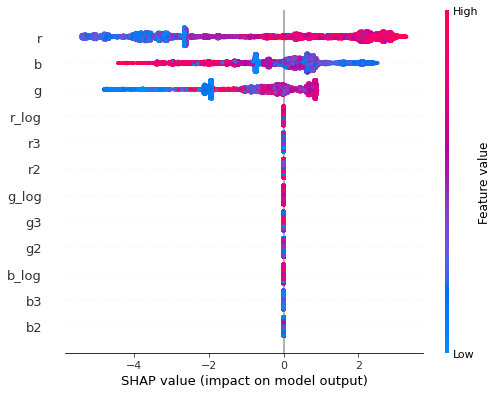

In [62]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_valid)

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать выводы и:
- чем больше r - тем больше тем больше вероятность того, что это skin (кожа)
- чем больше b - тем, напротив, больше вероятность того, что это не skin (кожа)
- чем ниже g - тем больше тем больше вероятность того, что это не skin (кожа), если же g велико - то это само по себе не влияет на ответ.
- Дополнительные признаки в данном случае не влияют на результат.

средние значения SHAP для каждого признака

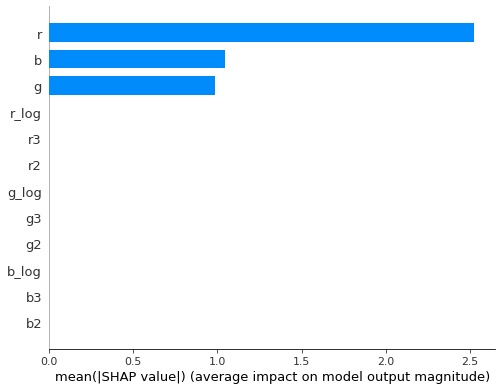

In [63]:
shap.summary_plot(shap_values, x_valid, plot_type="bar")

В среднем самый важный признак - r и признаки на его основе (логично, что красный цвет наиболее влияет на то, кожа ли это или нет).
Другие изначальные признаки также очень важны, а доп. фичи на их основе - не важны, т.е. в данном случае их нет особого смысла добавлять

Что значит в задании для топ-10 - я не понял.
поэтому взял ТОП-10  по значению самого важного признака r:

In [64]:
x_valid10 = x_valid.sort_values(by=['r'],ascending=False)
x_valid10

,b,g,r,b2,b3,b_log,g2,g3,g_log,r2,r3,r_log
20608,67,136,255,4489,300763,4.204693,18496,2515456,4.912655,65025,16581375,5.541264
31480,186,221,255,34596,6434856,5.225747,48841,10793861,5.398163,65025,16581375,5.541264
27376,159,137,255,25281,4019679,5.068904,18769,2571353,4.919981,65025,16581375,5.541264
906,55,119,255,3025,166375,4.007333,14161,1685159,4.779124,65025,16581375,5.541264
2697,147,184,255,21609,3176523,4.990433,33856,6229504,5.214936,65025,16581375,5.541264
...,...,...,...,...,...,...,...,...,...,...,...,...
36093,9,128,0,81,729,2.197226,16384,2097152,4.852030,0,0,-11.512925
50737,28,29,0,784,21952,3.332205,841,24389,3.367296,0,0,-11.512925
26462,3,8,0,9,27,1.098616,64,512,2.079443,0,0,-11.512925
38569,14,10,0,196,2744,2.639058,100,1000,2.302586,0,0,-11.512925


In [66]:
x_valid10 = x_valid10[:1029]
x_valid10

,b,g,r,b2,b3,b_log,g2,g3,g_log,r2,r3,r_log
20608,67,136,255,4489,300763,4.204693,18496,2515456,4.912655,65025,16581375,5.541264
31480,186,221,255,34596,6434856,5.225747,48841,10793861,5.398163,65025,16581375,5.541264
27376,159,137,255,25281,4019679,5.068904,18769,2571353,4.919981,65025,16581375,5.541264
906,55,119,255,3025,166375,4.007333,14161,1685159,4.779124,65025,16581375,5.541264
2697,147,184,255,21609,3176523,4.990433,33856,6229504,5.214936,65025,16581375,5.541264
...,...,...,...,...,...,...,...,...,...,...,...,...
17361,80,181,236,6400,512000,4.382027,32761,5929741,5.198497,55696,13144256,5.463832
287,142,169,236,20164,2863288,4.955827,28561,4826809,5.129899,55696,13144256,5.463832
19500,142,173,236,20164,2863288,4.955827,29929,5177717,5.153292,55696,13144256,5.463832
27782,94,182,236,8836,830584,4.543295,33124,6028568,5.204007,55696,13144256,5.463832


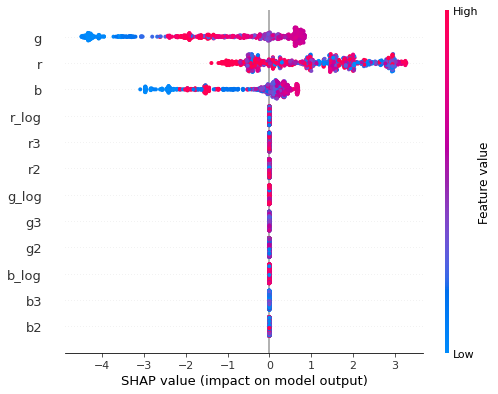

In [68]:
shap_values10 = explainer.shap_values(x_valid10)
shap.summary_plot(shap_values10, x_valid10)

При максимальных значениях r становится важным значение g - чем оно ниже - тем больше вероятность, что это не skin